In [1]:
import netCDF4 as nc
import datetime as dt
import pandas as pd
from pandas import Series, DataFrame
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import glob
import dateutil as dutil
from salishsea_tools import viz_tools, places
import xarray as xr
from salishsea_tools import evaltools as et

%matplotlib inline

### Determine model grid points using lat/log

In [2]:
jjii = xr.open_dataset('/data/sallen/MEOPAR/grid/grid_from_lat_lon_mask999.nc')

In [3]:
#Find model grid locations for IOS sampling sites
lat, lon = 49.250683, -123.748883 # GEO1 Sampling Site
method = 'nearest'
jj = jjii.jj.sel(lats=lat, lons=lon, method=method).item()
ii = jjii.ii.sel(lats=lat, lons=lon, method=method).item()
print (ii, jj)

245 487


In [4]:
#Find model grid locations for IOS sampling sites
lat, lon = 49.027867, -123.437 # STN 42 Sampling Site
method = 'nearest'
jj = jjii.jj.sel(lats=lat, lons=lon, method=method).item()
ii = jjii.ii.sel(lats=lat, lons=lon, method=method).item()
print (ii, jj)

263 422


In [5]:
#Find model grid locations for IOS sampling sites
lat, lon = 49.727300, -124.681 # STN 12 Sampling Site
method = 'nearest'
jj = jjii.jj.sel(lats=lat, lons=lon, method=method).item()
ii = jjii.ii.sel(lats=lat, lons=lon, method=method).item()
print (ii, jj)

168 646


In [6]:
jjii.close()

In [7]:
jGEO1,iGEO1=[487,245] ## Central SoG

In [8]:
jSTN42,iSTN42=[422,263] ## Central SoG

In [9]:
jSTN12,iSTN12=[646,168] ## Northern SoG

In [10]:
jSI,iSI=[343,198] ## Saanich Inlet

In [11]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    dept=np.copy(fm.variables['gdept_1d'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

### Observation Sampling Locations

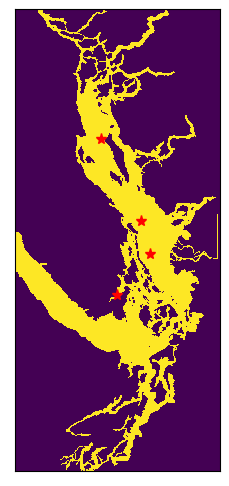

In [12]:
fig,ax=plt.subplots(1,1,figsize=(15,6))
ax.pcolormesh(tmask[0,0,:,:])

ax.plot(iGEO1,jGEO1,'r*',markersize=8)
ax.plot(iSTN42,jSTN42,'r*',markersize=8)
ax.plot(iSTN12,jSTN12,'r*',markersize=8)
ax.plot(iSI,jSI,'r*',markersize=8)
ax.set_aspect(1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#fig.savefig('ProductivityEvalSamplingSites.png',bbox_inches='tight',dip=1000)

In [13]:
t1=dt.datetime(2010,1,1) # 1st start date of run
#te=dt.datetime(2023,12,1)# last start date of runfnum=18
stm=np.shape(tmask)
nlen=365*2
#nlen=184
dlist1=[t1+dt.timedelta(days=ii) for ii in range(0,nlen)]

In [14]:
jpk20=0
for i in range(0,40): #stays same b/c grid cells or write len(dept[0]) instead of 40
    if dept[0][i]<=25:#change this to get diff depths in water column
        jpk20=i
print(jpk20)
jpk20=jpk20+1
print(jpk20)

20
21


In [15]:
koff=jpk20 # first index of depth > 100

In [16]:
tmaskC=np.copy(tmask)
tmaskC[:,koff:,:,:]=0

In [17]:
#sdir0='/results/SalishSea/nowcast-green/'
#sdir1='/results/SalishSea/hindcast/'
#sdir3='/data/eolson/MEOPAR/SS36runs/CedarRuns/spring2015_HCMZ/'
#sdir1='/results2/SalishSea/nowcast-green.201905/'
sdir1='/results2/SalishSea/nowcast-green.202111/'

In [18]:
tlist=dlist1
idir=sdir1
fformat1='%d%b%y/'
fformatT='SalishSea_1d_%Y%m%d_%Y%m%d_prod_T.nc'
fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_chem_T.nc'
PPDMD=np.zeros((len(tlist),))
PPDGEO1=np.zeros((len(tlist),))
PPDSTN42=np.zeros((len(tlist),))
PPDSTN12=np.zeros((len(tlist),))
PPDSI=np.zeros((len(tlist),))

ind=-1
for idt0 in tlist:
    ind=ind+1
    cdir=idt0.strftime(fformat1).lower()
    iffT=idt0.strftime(fformatT)
    iffP=idt0.strftime(fformatP)
    sffT=idir+cdir+iffT
    sffP=idir+cdir+iffP
    f=nc.Dataset(glob.glob(sffT)[0])
    if ind%15==0: print(sffT) 
    fP=nc.Dataset(glob.glob(sffP)[0])
    #e3t=fP.variables['e3t_0'][:2,:,:,:]
    Vol=A*e3t_0 #m3
    PPDMD=np.sum(f.variables['PPDIAT'][0,:,:,:]*e3t_0[0,:,:,:]*tmaskC[0,:,:,:],0)#mmol/m2 s-1
    PPDGEO1[ind]=np.sum(f.variables['PPDIAT'][0,:,jGEO1,iGEO1]*e3t_0[0,:,jGEO1,iGEO1]*tmaskC[0,:,jGEO1,iGEO1],0)#mmol/m2 s-1
    PPDSTN42[ind]=np.sum(f.variables['PPDIAT'][0,:,jSTN42,iSTN42]*e3t_0[0,:,jSTN42,iSTN42]*tmaskC[0,:,jSTN42,iSTN42],0)#mmol/m2 s-1
    PPDSTN12[ind]=np.sum(f.variables['PPDIAT'][0,:,jSTN12,iSTN12]*e3t_0[0,:,jSTN12,iSTN12]*tmaskC[0,:,jSTN12,iSTN12],0)#mmol/m2 s-1
    PPDSI[ind]=np.sum(f.variables['PPDIAT'][0,:,jSI,iSI]*e3t_0[0,:,jSI,iSI]*tmaskC[0,:,jSI,iSI],0)#mmol/m2 s-1
    
  #integrated=np.sum(f.variables['mesozooplankton'][il,:,:,:]*fe3t.variables['e3t'][il,:,:,:]*tmask[0,:,:,:],0)
   
    f.close()
    fP.close()

/results2/SalishSea/nowcast-green.202111/01jan10/SalishSea_1d_20100101_20100101_prod_T.nc
/results2/SalishSea/nowcast-green.202111/16jan10/SalishSea_1d_20100116_20100116_prod_T.nc
/results2/SalishSea/nowcast-green.202111/31jan10/SalishSea_1d_20100131_20100131_prod_T.nc
/results2/SalishSea/nowcast-green.202111/15feb10/SalishSea_1d_20100215_20100215_prod_T.nc
/results2/SalishSea/nowcast-green.202111/02mar10/SalishSea_1d_20100302_20100302_prod_T.nc
/results2/SalishSea/nowcast-green.202111/17mar10/SalishSea_1d_20100317_20100317_prod_T.nc
/results2/SalishSea/nowcast-green.202111/01apr10/SalishSea_1d_20100401_20100401_prod_T.nc
/results2/SalishSea/nowcast-green.202111/16apr10/SalishSea_1d_20100416_20100416_prod_T.nc
/results2/SalishSea/nowcast-green.202111/01may10/SalishSea_1d_20100501_20100501_prod_T.nc
/results2/SalishSea/nowcast-green.202111/16may10/SalishSea_1d_20100516_20100516_prod_T.nc
/results2/SalishSea/nowcast-green.202111/31may10/SalishSea_1d_20100531_20100531_prod_T.nc
/results2/

In [19]:
tlist=dlist1
idir=sdir1
fformat1='%d%b%y/'
fformatT='SalishSea_1d_%Y%m%d_%Y%m%d_prod_T.nc'
fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_chem_T.nc'
PPFMD=np.zeros((len(tlist),))
PPFGEO1=np.zeros((len(tlist),))
PPFSTN42=np.zeros((len(tlist),))
PPFSTN12=np.zeros((len(tlist),))
PPFSI=np.zeros((len(tlist),))

ind=-1
for idt0 in tlist:
    ind=ind+1
    cdir=idt0.strftime(fformat1).lower()
    iffT=idt0.strftime(fformatT)
    iffP=idt0.strftime(fformatP)
    sffT=idir+cdir+iffT
    sffP=idir+cdir+iffP
    f=nc.Dataset(glob.glob(sffT)[0])
    if ind%15==0: print(sffT) 
    fP=nc.Dataset(glob.glob(sffP)[0])
    #e3t=fP.variables['e3t'][:2,:,:,:]
    Vol=A*e3t_0 #m3
    PPFMD=np.sum(f.variables['PPPHY'][0,:,:,:]*e3t_0[0,:,:,:]*tmaskC[0,:,:,:],0)#mmol/m2 s-1
    PPFGEO1[ind]=np.sum(f.variables['PPPHY'][0,:,jGEO1,iGEO1]*e3t_0[0,:,jGEO1,iGEO1]*tmaskC[0,:,jGEO1,iGEO1],0)#mmol/m2 s-1
    PPFSTN42[ind]=np.sum(f.variables['PPPHY'][0,:,jSTN42,iSTN42]*e3t_0[0,:,jSTN42,iSTN42]*tmaskC[0,:,jSTN42,iSTN42],0)#mmol/m2 s-1
    PPDSTN12[ind]=np.sum(f.variables['PPPHY'][0,:,jSTN12,iSTN12]*e3t_0[0,:,jSTN12,iSTN12]*tmaskC[0,:,jSTN12,iSTN12],0)#mmol/m2 s-1
    PPFSI[ind]=np.sum(f.variables['PPPHY'][0,:,jSI,iSI]*e3t_0[0,:,jSI,iSI]*tmaskC[0,:,jSI,iSI],0)#mmol/m2 s-1
    
    
   
    f.close()
    fP.close()

/results2/SalishSea/nowcast-green.202111/01jan10/SalishSea_1d_20100101_20100101_prod_T.nc
/results2/SalishSea/nowcast-green.202111/16jan10/SalishSea_1d_20100116_20100116_prod_T.nc
/results2/SalishSea/nowcast-green.202111/31jan10/SalishSea_1d_20100131_20100131_prod_T.nc
/results2/SalishSea/nowcast-green.202111/15feb10/SalishSea_1d_20100215_20100215_prod_T.nc
/results2/SalishSea/nowcast-green.202111/02mar10/SalishSea_1d_20100302_20100302_prod_T.nc
/results2/SalishSea/nowcast-green.202111/17mar10/SalishSea_1d_20100317_20100317_prod_T.nc
/results2/SalishSea/nowcast-green.202111/01apr10/SalishSea_1d_20100401_20100401_prod_T.nc
/results2/SalishSea/nowcast-green.202111/16apr10/SalishSea_1d_20100416_20100416_prod_T.nc
/results2/SalishSea/nowcast-green.202111/01may10/SalishSea_1d_20100501_20100501_prod_T.nc
/results2/SalishSea/nowcast-green.202111/16may10/SalishSea_1d_20100516_20100516_prod_T.nc
/results2/SalishSea/nowcast-green.202111/31may10/SalishSea_1d_20100531_20100531_prod_T.nc
/results2/

In [20]:
PPtotalMD=PPDMD+PPFMD
PPtotalGEO1=PPDGEO1+PPFGEO1
PPtotalSTN42=PPDSTN42+PPFSTN42
PPtotalSTN12=PPDSTN12+PPFSTN12
PPtotalSI=PPDSI+PPFSI

In [21]:

#print(meanPPtotalMD.mean()*86400*6.6*12/1000)
print(PPtotalGEO1.mean()*86400*6.6*12/1000)
print(PPtotalSTN42.mean()*86400*6.6*12/1000)
print(PPtotalSTN12.mean()*86400*6.6*12/1000)
print(PPtotalSI.mean()*86400*6.6*12/1000)

0.7566533596957112
0.835978022238322
0.3021491268794465
0.8651047054818485


Text(0.5, 1.0, '2010 Depth-Integrated Primary Productivity (0-25)')

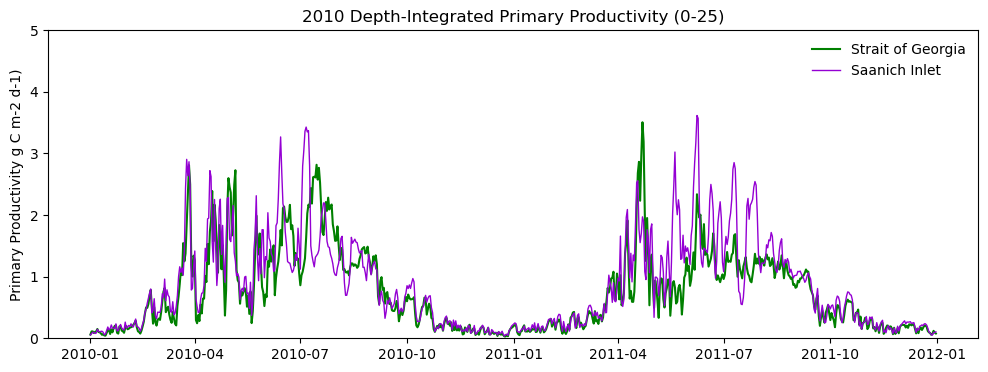

In [22]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
xticks=([32],[60],[91],[121],[213],[244],[274])

y=(3, 6, 7, 2, 1, 3, 4)

ax.plot(tlist,(PPtotalGEO1*86400*6.6*12/1000),'-',color='green',label='Strait of Georgia') #multiply by 86400 to get d-1
#ax.plot(tlist,(meanPPtotalSTN42*86400*6.6*12/1000),':',color='darkviolet',label='STN 42') #multiply by 86400 to get d-1
#ax.plot(tlist,(meanPPtotalSTN12*86400*6.6*12/1000),'.',color='orange',label='STN 12') #multiply by 86400 to get d-1
ax.plot(tlist,(PPtotalSI*86400*6.6*12/1000),'-',color='darkviolet',label='Saanich Inlet',linewidth=1) #multiply by 6.6 (C:N ratio) and 12 (weight of C)

ax.legend(frameon=False)
ax.set_ylim((0,5))
ax.set_ylabel('Primary Productivity g C m-2 d-1)')
ax.set_title('2010 Depth-Integrated Primary Productivity (0-25)')
#fig.savefig('SaanichTimeSeriesModelvsObsProductivity0-100m.jpg',bbox_inches='tight')


In [23]:
Model_SI_MarAug=(PPtotalSI[60:243]+PPtotalSI[425:608])/2

In [24]:
Model_SI_Annual=(PPtotalSI[0:364]+PPtotalSI[365:729])/2

In [25]:
Model_SoG_Aug=(PPtotalGEO1[213:243]+PPtotalGEO1[578:608])/2

In [26]:
Saanich2010=np.array([0.2, 0.16, 0.5, 3, 0.9, 9.14, 0.88, 0.44, 1.68, 1.36, 0.46, 0.64, 4.3, 1.04]) ## 2010 values from Suchy et al. 2016

Saanich2011=np.array([1.36, 1.04, 0.78, 0.24, 0.5, 5.0, 3.5, 2.0, 4.1, 0.52, 2.24]) # 2011 values from Suchy et al. 2016

SaanichSuchy=np.array([0.2, 0.16, 0.5, 3, 0.9, 9.14, 0.88, 0.44, 1.68, 1.36, 0.46, 0.64, 4.3, 1.04,\
           1.36, 1.04, 0.78, 0.24, 0.5, 5.0, 3.5, 2.0, 4.1, 0.52, 2.24])

SaanichKafrissen=np.array([0.41,0.46,1.01,4.37,5.41,1.49,15.16,1.47,0.74,2.58,2.11,0.74,1.03,6.84,1.77,0.34,\
                           3.67,0.56,0.45,0.11,0.28,0.87,0.92,1.06,3.20,0.72,0.19,0.25,0.07,0.25,2.30,1.18,1.41,\
                            1.06,2.16,0.01,0.62,0.76,1.22,0.14,0.19,0.31,1.52,2.13,0.89,1.97,1.24,0.70,1.46,0.12,\
                            0.03,0.78,0.69,0.10,0.13,0.07,0.03,0.03,0.03,0.09,0.09,0.16,0.23,0.38,1.60,8.45,1.75,3.05,\
                            0.20,0.63,0.03,0.03,0.09,0.09,0.16,0.23,0.38,1.60,8.45,1.75,3.05,0.20,0.63]) ## C uptake rates; Kafrissen et al. 2022


SaanichKafrissen_KSrevised=np.array([0.20,0.23,0.50,2.18,2.71,0.75,7.58,0.74,0.37,1.29,1.05,0.37,0.52,3.42,0.88,0.17,\
                                    1.83,0.28,0.23,0.05,0.14,0.44,0.46,0.53,1.60,0.36,0.09,0.12,0.04,0.13,1.15,0.59,0.71,\
                                    0.53,1.08,0.31,0.38,0.61,0.07,0.09,0.15,0.76,1.06,0.45,0.99,0.62,0.35,0.73,0.06,0.01,0.39,\
                                    0.35,0.05,0.07,0.04,0.01,0.01,0.02,0.05,0.04,0.08,0.11,0.19,0.80,4.22,0.87,1.52,0.10,0.32]) ## corrected C uptake values based on calculations from Saanich 2010-2011 raw data



SoG=np.array([0.2,1.2]) # from Harrison et al. 1983

SoGYin=np.array([0.3, 0.5, 0.4, 0.6, 0.7, 1.6, 0.6,\
       1.7, 1.6, 1.0, 1.1, 1.0, 0.9, 0.4,\
       0.4, 0.5, 0.8,2.4, 1.9, 1.5, 2.1,\
       0.8, 1.0, 1.5, 1.5, 2.4, 1.4, 1.5,\
       1.2, 1.2, 0.6, 2.0, 1.7, 2.7, 2.5]) ## From Yin et al. 1997. for August only. Could also include the 8.0 value from Stockner et al. 1979?

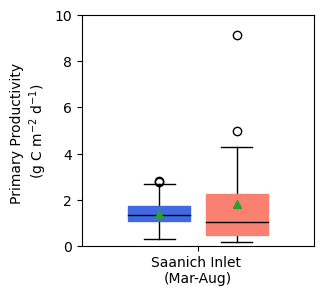

In [27]:
def color_boxplot(data, color, pos=[0], ax=None):
    ax = ax or plt.gca()
    bp = ax.boxplot(data, patch_artist=True,  showmeans=True, positions=pos,widths=0.4)
    for item in ['boxes']:
        plt.setp(bp[item], color=color)
    for item in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color='k')


data1 = [Model_SI_MarAug*86400*6.6*12/1000]
data2 = [SaanichSuchy]
#data3 = [mod_AugustSoG*86400*6.6*12/1000]
#data4 = [SoGYin]

fig, ax = plt.subplots(figsize=(3,3))
bp1 = color_boxplot(data1, 'royalblue',[1])
bp2 = color_boxplot(data2, 'salmon', [1.5])
#bp3 = color_boxplot(data3, 'royalblue', [2.5])
#bp4 = color_boxplot(data4, 'salmon', [3])
#ax.autoscale()
ax.set(xticks=[1.25], xticklabels=['Saanich Inlet \n(Mar-Aug)'])
ax.set_ylim(0,10)
ax.set_ylabel('Primary Productivity \n(g C m$^{-2}$ d$^{-1}$)')
#ax.legend()
plt.show()

In [28]:
Model_SI_MarAug.mean()*86400*6.6*12/1000

1.397147208780758

In [29]:
SaanichSuchy.mean()

1.8392000000000002

In [30]:
## Saanich Inlet Ratio (Mar-Aug) using Suchy et al. 2016 data

ratio_modPPvsobsPP_SI=(Model_SI_MarAug.mean()*86400*6.6*12/1000)/(SaanichSuchy.mean())
print(ratio_modPPvsobsPP_SI)

0.7596494175623955


In [31]:
SaanichSuchy.min()

0.16

In [32]:
SaanichSuchy.max()

9.14

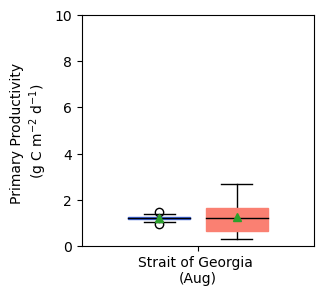

In [33]:
def color_boxplot(data, color, pos=[0], ax=None):
    ax = ax or plt.gca()
    bp = ax.boxplot(data, patch_artist=True,  showmeans=True, positions=pos,widths=0.4)
    for item in ['boxes']:
        plt.setp(bp[item], color=color)
    for item in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color='k')


data1 = [Model_SoG_Aug*86400*6.6*12/1000]
data2 = [SoGYin]


fig, ax = plt.subplots(figsize=(3,3))
bp1 = color_boxplot(data1, 'royalblue',[1])
bp2 = color_boxplot(data2, 'salmon', [1.5])
#bp3 = color_boxplot(data3, 'royalblue', [2.5])
#bp4 = color_boxplot(data4, 'salmon', [3])
#ax.autoscale()
ax.set(xticks=[1.25], xticklabels=['Strait of Georgia \n(Aug)'])
ax.set_ylim(0,10)
ax.set_ylabel('Primary Productivity \n(g C m$^{-2}$ d$^{-1}$)')
#ax.legend()
plt.show()

In [34]:
Model_SoG_Aug.mean()*86400*6.6*12/1000

1.2140633485713461

In [35]:
SoGYin.mean()

1.2571428571428573

In [36]:
## SoG Ratio (for August only)

ratio_modPPvsobsPP_SoG=(Model_SoG_Aug.mean()*86400*6.6*12/1000)/(SoGYin.mean())
print(ratio_modPPvsobsPP_SoG)

0.9657322090908433


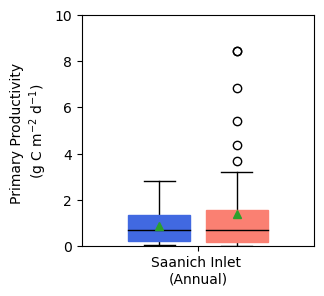

In [37]:
def color_boxplot(data, color, pos=[0], ax=None):
    ax = ax or plt.gca()
    bp = ax.boxplot(data, patch_artist=True,  showmeans=True, positions=pos,widths=0.4)
    for item in ['boxes']:
        plt.setp(bp[item], color=color)
    for item in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color='k')


data1 = [Model_SI_Annual*86400*6.6*12/1000]
data2 = [SaanichKafrissen]
#data3 = [mod_AugustSoG*86400*6.6*12/1000]
#data4 = [SoGYin]

fig, ax = plt.subplots(figsize=(3,3))
bp1 = color_boxplot(data1, 'royalblue',[1])
bp2 = color_boxplot(data2, 'salmon', [1.5])
#bp3 = color_boxplot(data3, 'royalblue', [2.5])
#bp4 = color_boxplot(data4, 'salmon', [3])
#ax.autoscale()
ax.set(xticks=[1.25], xticklabels=['Saanich Inlet \n(Annual)'])
ax.set_ylim(0,10)
ax.set_ylabel('Primary Productivity \n(g C m$^{-2}$ d$^{-1}$)')
#ax.legend()
plt.show()

In [38]:
Model_SI_Annual.mean()*86400*6.6*12/1000

0.8670446651855012

In [39]:
SaanichKafrissen.mean()

1.3871084337349397

In [40]:
SaanichKafrissen.min()

0.01

In [41]:
SaanichKafrissen.max()

15.16

In [42]:
## Saanich Inlet Ratio using Kafrissen et al. 2022 data

ratio_modPPvsobsPP_SI=(Model_SI_Annual.mean()*86400*6.6*12/1000)/(SaanichKafrissen.mean())
print(ratio_modPPvsobsPP_SI)

0.6250734579205819


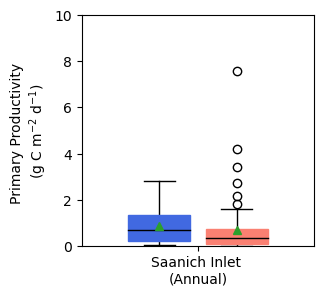

In [59]:
def color_boxplot(data, color, pos=[0], ax=None):
    ax = ax or plt.gca()
    bp = ax.boxplot(data, patch_artist=True,  showmeans=True, positions=pos,widths=0.4)
    for item in ['boxes']:
        plt.setp(bp[item], color=color)
    for item in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color='k')


data1 = [Model_SI_Annual*86400*6.6*12/1000]
data2 = [SaanichKafrissen_KSrevised]
#data3 = [mod_AugustSoG*86400*6.6*12/1000]
#data4 = [SoGYin]

fig, ax = plt.subplots(figsize=(3,3))
bp1 = color_boxplot(data1, 'royalblue',[1])
bp2 = color_boxplot(data2, 'salmon', [1.5])
#bp3 = color_boxplot(data3, 'royalblue', [2.5])
#bp4 = color_boxplot(data4, 'salmon', [3])
#ax.autoscale()
ax.set(xticks=[1.25], xticklabels=['Saanich Inlet \n(Annual)'])
ax.set_ylim(0,10)
ax.set_ylabel('Primary Productivity \n(g C m$^{-2}$ d$^{-1}$)')
#ax.legend()
plt.show()

In [50]:
Model_SI_Annual.mean()*86400*6.6*12/1000

0.8670446651855012

In [55]:
SaanichKafrissen_KSrevised.mean()

0.7130434782608696

In [56]:
SaanichKafrissen_KSrevised.min()

0.01

In [57]:
SaanichKafrissen_KSrevised.max()

7.58

In [58]:
## Saanich Inlet Ratio using Kafrissen et al. 2022 data but revised by me

ratio_modPPvsobsPP_SI=(Model_SI_Annual.mean()*86400*6.6*12/1000)/(SaanichKafrissen_KSrevised.mean())
print(ratio_modPPvsobsPP_SI)

1.21597727434552
